<a href="https://colab.research.google.com/github/chriskavanagh97/Ahealthstore/blob/master/fypmachinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
!pip install -q tf-hub-nightly==0.8.0.dev201911110007
!pip install -q git+https://github.com/tensorflow/examples

TensorFlow 2.x selected.
     |████████████████████████████████| 92kB 3.3MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow_examples.lite.model_customization.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_customization.core.task import image_classifier
from tensorflow_examples.lite.model_customization.core.task.model_spec import efficientnet_b0_spec
from tensorflow_examples.lite.model_customization.core.task.model_spec import ImageModelSpec

import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
image_path='/content/drive/My Drive/TFLite/dataset-resized'

In [0]:
data = ImageClassifierDataLoader.from_folder(image_path)

INFO:tensorflow:Load image with size: 2527, num_label: 6, labels: cardboard, glass, metal, paper, plastic, trash.


INFO:tensorflow:Load image with size: 2527, num_label: 6, labels: cardboard, glass, metal, paper, plastic, trash.


In [0]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

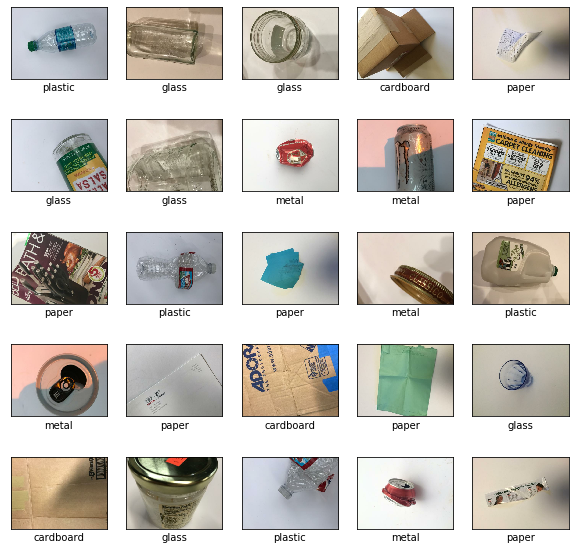

In [0]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.dataset.take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

In [0]:
model = image_classifier.create(train_data, validation_data=validation_data)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________
None
INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Train for 63 steps, validate for 7 steps
Epoch 1/5
63/63 [==============================] - 99s 2s/step - loss: 1.2410 - accuracy: 0.6181 - val_loss: 0.9225 - val_accuracy: 0.7857
Epoch 2/5
63/63 [==============================] - 91s 1s/step - loss: 0.8641 - accuracy: 0.8170 - val_loss: 0.9082 - val_accuracy: 0.7723
Epoch 3/5
63/63 [==============================] - 90s 1s/step - loss: 0.7872 - accuracy: 0.8467 - val_loss: 0.9137 - val_accuracy: 0.7679
Epoch 4/5
63/63 [==============================] - 90s 1s/step - loss: 0.7356 - accuracy: 0.8795 - val_loss: 0.8672 - val_accuracy: 0.8170
Epoch 5/5
63/63 [==============================] - 91s 1s/step - loss: 0.7114 - accuracy: 0.8909 - val_loss: 0.8786 - val_accuracy: 0.8125


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
loss, accuracy = model.evaluate(test_data)

8/8 [==============================] - 13s 2s/step - loss: 0.8045 - accuracy: 0.8538


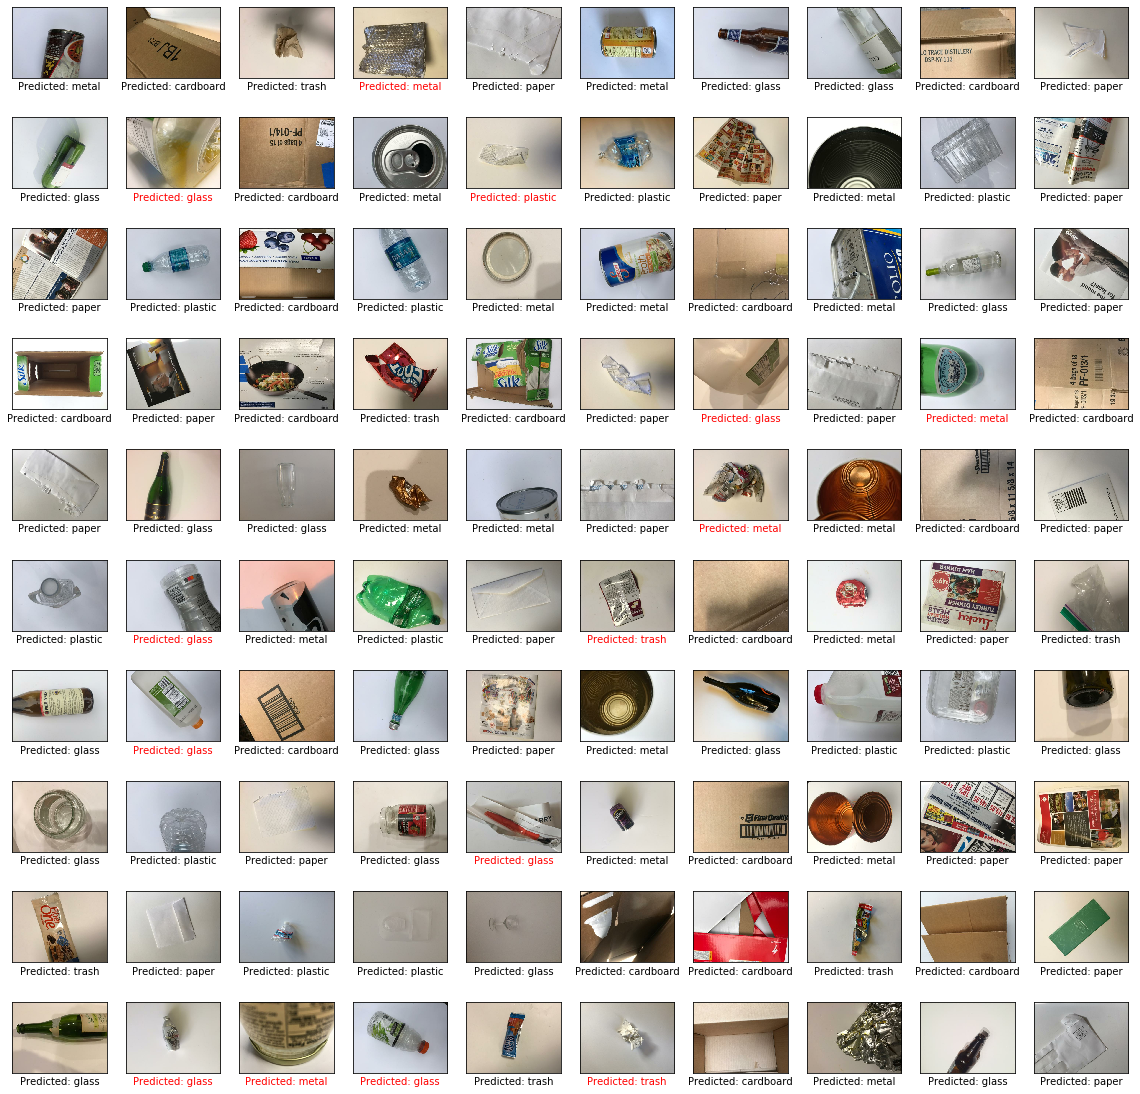

In [0]:
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.dataset.take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

In [0]:
model.export('recycle_classifier.tflite', 'recycle_labels.txt')

INFO:tensorflow:Export to tflite model recycle_classifier.tflite, saved labels in recycle_labels.txt.


INFO:tensorflow:Export to tflite model recycle_classifier.tflite, saved labels in recycle_labels.txt.


In [0]:
# Read TensorFlow Lite model from TensorFlow Lite file.
with tf.io.gfile.GFile('recycle_classifier.tflite', 'rb') as f:
  model_content = f.read()

# Read label names from label file.
with tf.io.gfile.GFile('recycle_labels.txt', 'r') as f:
  label_names = f.read().split('\n')

# Initialze TensorFlow Lite inpterpreter.
interpreter = tf.lite.Interpreter(model_content=model_content)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

# Run predictions on each test image data and calculate accuracy.
accurate_count = 0
for i, (image, label) in enumerate(test_data.dataset):
    # Pre-processing should remain the same. Currently, just normalize each pixel value and resize image according to the model's specification.
    image, _ = model.preprocess(image, label)
    # Add batch dimension and convert to float32 to match with the model's input
    # data format.
    image = tf.expand_dims(image, 0).numpy()

    # Run inference.
    interpreter.set_tensor(input_index, image)
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the label with highest
    # probability.
    predict_label = np.argmax(output()[0])
    # Get label name with label index.
    predict_label_name = label_names[predict_label]

    accurate_count += (predict_label == label.numpy())

accuracy = accurate_count * 1.0 / test_data.size
print('TensorFlow Lite model accuracy = %.4f' % accuracy)

TensorFlow Lite model accuracy = 0.8538
